# **Analisis de sentimientos de comentarios de películas**

### Integrantes:
* **Ángela Vargas:** Desempeñó el rol de Líder de analítica al encargarse de probar los modelos y determinar cual es el mejor según las restricciones del cliente 
* **Juan Martin Santos:** Desempeñó el rol de lider de negocio asumiendo la responsabilidad de identificar la estrategia utilizada para alcanzar el objetivo del negocio.
* **Daniel Osorio:** Desempeño el rol de Líder de proyecto definiendo las fechas de reuniones y asignando los tareas equitativamente entre los integrantes. También desempñó el rol de lider de datos al haber realizado la limpieza de los datos y haberla dejado disponible para todos los integrantes.

## **Caso**

| Pregunta de entendimiento | Justificación |
| --- | --- |
| **¿Cuáles son los objetivos del negocio?** | En este caso asumimos que nuestro cliente es una página de streaming que desea tomar las reviews de las películas de su plataforma para y determinar si esta debe reemplazarse por una nueva película que pueda generar un mejor sentimiento a la audiencia o no. El sentimiento viene dado por la cantidad de buenas y malas reviews que tenga, entre mas reviews negativas tenga, peor es el sentimiento de la película. |
| **¿Cuáles son los criterios de éxito?** | Nuestro principal criterio de éxito es la precisión, ya que determinar erroneamente el sentimiento de una película puede afectar al negocio en la toma de decisiones sobre el estado de una película dentro de su plataforma. |
| **¿Cuál es la Oportunidad / problema del negocio?** | Al usar aprendizaje automático, el negocio se puede beneificar al ser más eficiente en la forma en que determinar si una película debe quedarse o no, haciendo que el público en general esté más satisfecho con el contenido que consume aumentando la fidelidad y posibles ganancias. |
| **¿Cuál es el Enfoque Analítico?** | Desde el punto de vista del aprendizaje automático, el problema se enfoca en algoritmos de clasificación en el análisis de textos. De esta forma, se etá realizando el análisis de sentimientos de películas. Este proyecto tiene comentarios de películas en español, que deben ser clasificadas en las categorías de positivo, negativo. Esto por medio de técnicas para el procesamiento de lenguaje natural. |
| **¿Quienes estan siendo beneficiados?** | El principal beneficiado a parte del negocio son los clientes que van a poder determinar tener más decisión sobre el catálogo que ofrece la empresa de streaming |
| **¿Cuáles son las técnicas y algoritmos a utilizar?** | Haremos uso de Multinomial Naives Bayes, Random forest y regresión logística |

## **Entendimiento de los datos**
Primero vamos a cargar los datos en un DataFrame para luego revisar la calidad de estos en cuanto a completitud, consistencia y unicidad.

In [1]:
pip install langdetect

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import nltk
# Se descargan las stopwords (despues se usan para eliminar palabras que no aportan informacion)
nltk.download('stopwords')
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from langdetect import detect

# Este comando es requerido para que las visualizaciones se muestren en este notebook
%matplotlib inline

[nltk_data] Downloading package stopwords to /Users/marts/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
pd.set_option('display.max_columns', None) # Número máximo de columnas a mostrar
pd.set_option('display.max_rows', 50) # Numero máximo de filas a mostar

In [4]:
# Lectura de datos en formato CSV
# Los datos son almacenados en memoria usando una estructura de datos de Pandas conocida como dataframe
df_reviews = pd.read_csv('./data/MovieReviews.csv')

In [5]:
# Muestra el numero de filas y columnas del dataframe
df_reviews.shape

(5000, 3)

In [6]:
# Muestra de 5 filas aleatorias del dataframe
df_reviews.sample(5)

,Unnamed: 0,review_es,sentimiento
2564,2564,He visto un montón de películas originales del...,negativo
1705,1705,"Siempre he sido un gran fanático del ""homicidi...",positivo
4347,4347,"Fue una experiencia dolorosa, toda la historia...",negativo
1800,1800,Tuve la suerte de asistir al primer ministro L...,positivo
3944,3944,LL Cool J. Morgan Freeman. Dylan McDermott. Ke...,negativo


In [7]:
# Muestra el tipo de datos de cada columna
df_reviews.dtypes

Unnamed: 0      int64
review_es      object
sentimiento    object
dtype: object

In [8]:
# Muestra los diferentes valores de la columna sentimiento
df_reviews['sentimiento'].value_counts()

positivo    2500
negativo    2500
Name: sentimiento, dtype: int64

Como podemos observar, tenemos 5000 registros (reviews) de los cuales la mitad corresponden a reviews positivas y la otra mitad a reviews negativas. Existe consistencia en los valores de la columna sentimiento. Como existen 2500 positivos y 2500 negativos, podemos decir que la completitud de los datos para la columna sentimiento es del 100%, vamos a revisar ahora la completitud para la columna *review_es*.

In [9]:
# Muestra la cantidad de valores nulos para la columna review_es
df_reviews['review_es'].isnull().sum()

0

Ahora, verificaremos la unicidad de los valores de la columnas "review_es". Este paso es importante ya que al identificar registros duplicados, podemos tomar medidas que nos ayudan a mejorar la precision y eficiencia de los modelos que realizaremos.

In [10]:
df_reviews['review_es'].duplicated().sum()

2

Por ultimo, verificaremos el idioma en el que se encuentran los comentarios.

In [11]:
# Primero creamos el diccionario de los idiomas en los que estan los comentarios
langs = {}

# Luego iteramos sobre cada comentario y determinamos su idioma
for index, row in df_reviews.iterrows():
    if detect(row['review_es']) not in langs:
        langs[detect(row['review_es'])] = 1
    else:
        langs[detect(row['review_es'])] += 1

print(langs)

{'es': 4803, 'en': 196, 'id': 1}


Como podemos observar, tenemos una completitud del 100% en la columna review_es, por lo que no es necesario realizar ningún tipo de limpieza de datos a nivel de intregridad y completitud de los datos. Sin embargo, nos percatamos que dentro del conjunto de datos hay comentarios que no estan en español y que hay comentarios repetidos, por lo que obtaremos por eliminar estas filas, esta decision se toma debido a las necesidades del negocio de analisar comentarios en español.
## **Preprocesamiento**


Primero comenzaremos por cambiar las variables de sentimiento que son positivo y negativo por 0 (siendo negativo) y 1 (siendo positivo)

In [12]:
df_reviews['sentimiento'].replace({'negativo': 0, 'positivo': 1}, inplace=True)
df_reviews['sentimiento'].value_counts()

1    2500
0    2500
Name: sentimiento, dtype: int64

Para encargarnos de los comentarios repetidos obtamos por eliminar los registros. Estos no significan una gran parte de los datos por lo que quitarlos nos ayudara en el mejor funcionamiento del algoritmo

In [13]:
df_reviews['review_es'].drop_duplicates(inplace=True)

Como libreria para limpiar las filas con los comentarios en ingles usaremos langdetect que nos permitira tomar todo el comentario y determinar el idioma en el que esta.

In [14]:
#Iteramos en cada una de las filas del dataframe
for index, row in df_reviews.iterrows():
    # Si el valor de la fila es en la elimina
    if detect(row['review_es']) != 'es':
        df_reviews.drop(index, inplace=True)

Como libreria para el procesamiento de lenguaje natural vamos a utilizar NLTK (Natural Language Tool Kit). Primero definimos un set de stopwords en español. Las stopwords son esas palabras que no aportan significado al texto para la tarea de clasificación. Estas palabras vacías pueden ser conectores propios del idioma, pronombres o puntos y comas. Algunas stopwords del español son por ejemplo las siguientes.

In [15]:
# Seteamos las stopwords en español
stop_words = set(stopwords.words('spanish'))
# Agregamos a las stopwords tambien los signos de puntuacion
# Se agrega una u a la izquierda para indicar que es un string unicode, sin embargo no es necesario
stop_words = list(stop_words)
stop_words.extend([u'.', u'[', ']', u',', u';', u'', u')', u'),', u' ', u'('])
print(stop_words)

['él', 'esta', 'yo', 'habiendo', 'desde', 'éramos', 'porque', 'habré', 'habríamos', 'o', 'hayamos', 'durante', 'sus', 'habidas', 'seríais', 'tuyas', 'los', 'hayáis', 'suya', 'el', 'algo', 'hubiéramos', 'algunas', 'ese', 'tendrían', 'fueses', 'hubisteis', 'que', 'tuviera', 'no', 'ante', 'hubo', 'estarán', 'estarás', 'tendréis', 'eran', 'estabais', 'a', 'tuvieses', 'cual', 'fueras', 'míos', 'fuimos', 'nos', 'habrás', 'sentidos', 'muy', 'eres', 'fuesen', 'estará', 'habíamos', 'estaríais', 'habremos', 'estoy', 'suyas', 'quien', 'una', 'habéis', 'soy', 'han', 'estaban', 'todos', 'estuviésemos', 'fueseis', 'erais', 'había', 'eras', 'hubierais', 'tú', 'teniendo', 'para', 'estuve', 'tuviste', 'tuvieron', 'estuvimos', 'fuésemos', 'estéis', 'suyos', 'su', 'tus', 'hubiste', 'tuyo', 'algunos', 'seáis', 'tenéis', 'hubiese', 'e', 'por', 'nada', 'hemos', 'seríamos', 'tengas', 'este', 'habías', 'sentidas', 'estabas', 'será', 'fuerais', 'estado', 'era', 'hubiera', 'estuvierais', 'tengáis', 'estuvieseis

Luego se utiliza el Snowball stemming algorithm, este algoritmo lo que hace es transformar/reducir las palabras a su forma base, aqui hacemos un ejemplo con la palabra 'corriendo' y 'correr'

In [16]:
snowball_stemmer = SnowballStemmer('spanish')
snowball_stemmer.stem('corriendo')

'corr'

In [17]:
snowball_stemmer.stem('correr')

'corr'

Para tokenizar utilizamos la función *wordpunct_tokenize()* que tiene la libreria NLTK. Esta función, a diferencia de la función *word_tokenize()*, almacena los signos de puntuación como tokens diferentes. El *word.isapha()* es para revisar que la palabra no sea de una sola letra como por ejemplo 'y'. Luego se revisa que la palabra en minuscula no esté entre las stopwords antes de tokenizarla. A continuación un ejemplo de como funciona

In [18]:
# Ejemplo de como se tokenizan las palabras de una reseña
review_example = "Este es un ejemplo de una reseña en español."
review_tokens = [word.lower() for word in wordpunct_tokenize(review_example) if word.isalpha() and word.lower() not in stop_words]
print(review_tokens)

['ejemplo', 'reseña', 'español']


Ahora aplicamos esto para cada fila de la columna 'review_es'. Para esto definimos la funcion lamba a cada fila de la columna review utilizando el metodo apply. Se hace todo el proceso de tokenizacion mostrado anteriormente y se vuelve a juntar el texto con el metodo join(). El string resultante es ahora el nuevo valor para la fila en la columna 'review_es'.

In [19]:
df_reviews['review_es'] = df_reviews['review_es'].apply(lambda x: ' '.join([snowball_stemmer.stem(word.lower()) for word in wordpunct_tokenize(x) if (word.isalpha() and word.lower() not in stop_words)]))

In [20]:
df_reviews['review_es'].head(5)

0    si busc pelicul guerr tipic asi not aficion gu...
1    supong director pelicul luj sent busc abrig gr...
2    dificil cont pelicul estrop disfrut esper vien...
3    pelicul comienz lent estil vid wallac napalm a...
4    pelicul verdader accion maxim expresion mejor ...
Name: review_es, dtype: object

Usamos el *CountVectorizer()* que nos da la cuenta de cada de cada palabra para cada review, lo cual podemos usar para los modelos que crearemos a continuación.

In [21]:
# Extraer la cuenta de cada palabra para cada review
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_reviews['review_es'])
y = df_reviews['sentimiento']

In [22]:
# Dividimos los datos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## **Modelos**

### **Multinomial Naive Bayes**

Escogimos este algoritmo porque trabaja muy bien con datos discretos, lo cual lo hace especialmente bueno para una tarea de clasificacion como si el comentario es positivo o negativo. El algoritmo realiza el calculo de la probabilidad de que cada palabra de una review pertenezca a una clase (positivo o negativo) y luego utiliza estas probabilidades con el teorema de Bayes para calcular la probabilidad de que una review pertenezca a una clase. El algoritmo asume que la probabilidad de una palabra es independiente de las otras, por lo cual es llamado 'naive' Bayes.

In [23]:
# Entrenar el modelo
multinomialNB = MultinomialNB()
multinomialNB.fit(X_train, y_train)

# Predicción
y_train_pred = multinomialNB.predict(X_train)
y_pred = multinomialNB.predict(X_test)

# Metricas de evaluacion
print('Exactitud sobre test: %.2f' % accuracy_score(y_test, y_pred))
print("Recall: {}".format(recall_score(y_test, y_pred, pos_label=1)))
print("Precisión: {}".format(precision_score(y_test, y_pred, pos_label=1)))
print("Puntuación F1: {}".format(f1_score(y_test, y_pred, pos_label=1)))

Exactitud sobre test: 0.82
Recall: 0.8012684989429175
Precisión: 0.8293216630196937
Puntuación F1: 0.8150537634408603


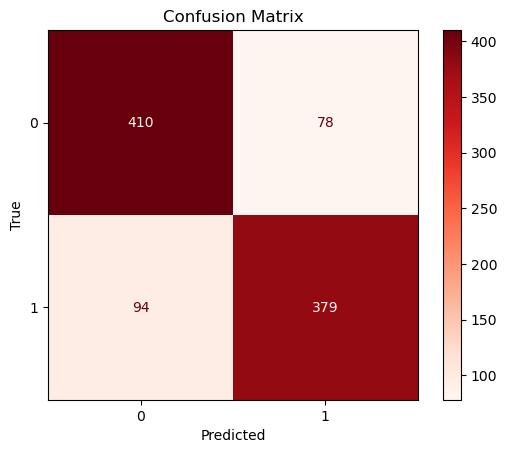

In [24]:
# Matriz de confusion
cm = confusion_matrix(y_test, y_pred)

# Crear una instancia de ConfusionMatrixDisplay con la matriz de confusión
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

# Mostrar la matriz de confusión utilizando la función plot() de ConfusionMatrixDisplay
cm_display.plot(cmap='Reds')

# Añadir etiquetas y títulos
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Mostrar la matriz de confusión
plt.show()

### Random forest
Escogimos este algoritmo porque este es capaz de manejar caracteristicas de alta dimension lo que favorece en el analisis de texto por la extension de los mismos. Ademas, maneja muy bien el overfitting. El algoritmo se basa en arboles de decision y funciona de la siguiente forma: Selecciona aleatoriamente un subconjunto de muestras; Selecciona aleatoriamente un subconjunto de caracteristicas; con las muestras y caracteristicas seleccionadas se construyen varios arboles de decision; por ultimo se selecciona el arbol de decision que obtiene mayor votacion dados sus resultados.

In [25]:
# Creamos el clasificador de random forest con 100 arboles
rf = RandomForestClassifier(n_estimators=1000, random_state=0)
# Entrenamos el modelo
y_train_pred_rf = rf.fit(X_train, y_train)
# Realizamos la predicción
y_pred_rf = rf.predict(X_test)

# Metricas de evaluacion
print('Exactitud sobre test: %.2f' % accuracy_score(y_test, y_pred_rf))
print("Recall: {}".format(recall_score(y_test, y_pred_rf, pos_label=1)))
print("Precisión: {}".format(precision_score(y_test, y_pred_rf, pos_label=1)))
print("Puntuación F1: {}".format(f1_score(y_test, y_pred_rf, pos_label=1)))

Exactitud sobre test: 0.84
Recall: 0.8520084566596194
Precisión: 0.8343685300207039
Puntuación F1: 0.8430962343096234


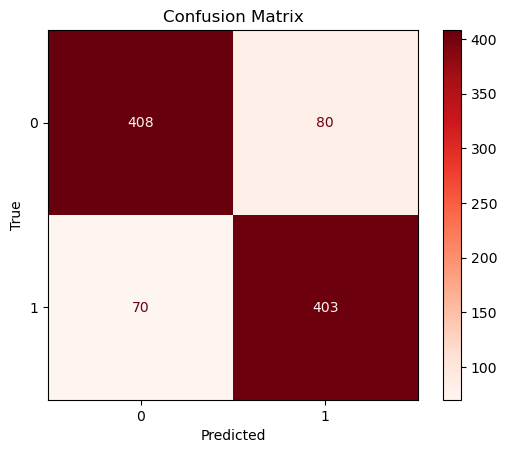

In [26]:
# Matriz de confusion
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Crear una instancia de ConfusionMatrixDisplay con la matriz de confusión
cm_rf_display = ConfusionMatrixDisplay(confusion_matrix=cm_rf)

# Mostrar la matriz de confusión utilizando la función plot() de ConfusionMatrixDisplay
cm_rf_display.plot(cmap='Reds')

# Añadir etiquetas y títulos
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Mostrar la matriz de confusión
plt.show()

### Regresión logística
Escogimos este algoritmo porque la regresión logística es particularmente adecuada para problemas de clasificación binaria, es decir, cuando solo hay dos categorías posibles (en este caso, positivo o negativo). En estos casos, la regresión logística puede ser más eficiente y precisa que otros algoritmos. Los coeficientes del modelo pueden utilizarse para determinar qué palabras o características tienen más influencia en la clasificación de los comentarios como positivos o negativos. Además puede escalar bien con grandes conjuntos de datos y se puede mejorar mediante técnicas avanzadas de optimización.

In [27]:
# Crear un modelo de regresión logística y ajustarlo a los datos de entrenamiento
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Hacer predicciones en los datos de prueba y calcular la precisión
y_pred_lr = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_lr)

print("Precisión de la regresión logística:", accuracy)
# Metricas de evaluacion
print('Exactitud sobre test: %.2f' % accuracy_score(y_test, y_pred_lr))
print("Recall: {}".format(recall_score(y_test, y_pred_lr, pos_label=1)))
print("Precisión: {}".format(precision_score(y_test, y_pred_lr, pos_label=1)))
print("Puntuación F1: {}".format(f1_score(y_test, y_pred_lr, pos_label=1)))

Precisión de la regresión logística: 0.8480749219562955
Exactitud sobre test: 0.85
Recall: 0.86892177589852
Precisión: 0.8303030303030303
Puntuación F1: 0.8491735537190082


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


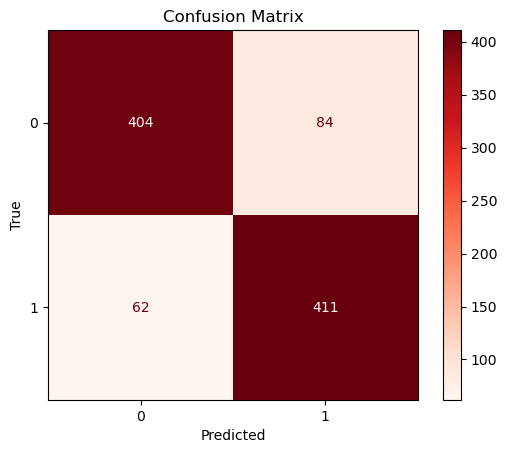

In [28]:
# Matriz de confusion
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Crear una instancia de ConfusionMatrixDisplay con la matriz de confusión
cm_lr_display = ConfusionMatrixDisplay(confusion_matrix=cm_lr)

# Mostrar la matriz de confusión utilizando la función plot() de ConfusionMatrixDisplay
cm_lr_display.plot(cmap='Reds')

# Añadir etiquetas y títulos
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Mostrar la matriz de confusión
plt.show()

#### Regresion logistica con mas iteraciones
Dado que se obtuvo un warning que decia que no se alcanzo la convergencia se sugeria aumentar el numero maximo de iteraciones, el que esta por defecto es 100 por lo tanto se decide establecer un valor mayor como 1000.

In [29]:
# Crear un modelo de regresión logística y ajustarlo a los datos de entrenamiento
lr_1 = LogisticRegression(max_iter=1000)
lr_1.fit(X_train, y_train)

# Hacer predicciones en los datos de prueba y calcular la precisión
y_pred_lr_1 = lr_1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_lr_1)

print("Precisión de la regresión logística:", accuracy)
# Metricas de evaluacion
print('Exactitud sobre test: %.2f' % accuracy_score(y_test, y_pred_lr_1))
print("Recall: {}".format(recall_score(y_test, y_pred_lr_1, pos_label=1)))
print("Precisión: {}".format(precision_score(y_test, y_pred_lr_1, pos_label=1)))
print("Puntuación F1: {}".format(f1_score(y_test, y_pred_lr_1, pos_label=1)))

Precisión de la regresión logística: 0.8480749219562955
Exactitud sobre test: 0.85
Recall: 0.86892177589852
Precisión: 0.8303030303030303
Puntuación F1: 0.8491735537190082


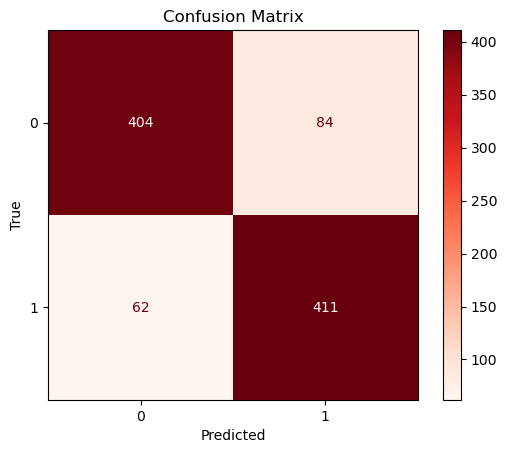

In [30]:
# Matriz de confusion
cm_lr_1 = confusion_matrix(y_test, y_pred_lr_1)

# Crear una instancia de ConfusionMatrixDisplay con la matriz de confusión
cm_lr_1_display = ConfusionMatrixDisplay(confusion_matrix=cm_lr_1)

# Mostrar la matriz de confusión utilizando la función plot() de ConfusionMatrixDisplay
cm_lr_1_display.plot(cmap='Reds')

# Añadir etiquetas y títulos
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Mostrar la matriz de confusión
plt.show()

#### Regresion logistica con otro algoritmo de optimizacion
Dado que aumentar el numero maximo de iteraciones no mejoro el modelo se decidio probar con otro algoritmo de optimizacion. El algoritmo utilizado por defecto es 'lbfgs' (este utiliza el método de optimización de cuasi-Newton Broyden-Fletcher-Goldfarb-Shanno (BFGS)) para optimizar los parámetros del modelo). Se decide intentar con saga que utiliza una versión mejorada del método de promedio de gradientes estocásticos que admite regularización elástica y regularización L1.

In [31]:
# Crear un modelo de regresión logística y ajustarlo a los datos de entrenamiento
lr_2 = LogisticRegression(max_iter=1000,solver='saga')
lr_2.fit(X_train, y_train)

# Hacer predicciones en los datos de prueba y calcular la precisión
y_pred_lr_2 = lr_2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_lr_2)

print("Precisión de la regresión logística:", accuracy)
# Metricas de evaluacion
print('Exactitud sobre test: %.2f' % accuracy_score(y_test, y_pred_lr_2))
print("Recall: {}".format(recall_score(y_test, y_pred_lr_2, pos_label=1)))
print("Precisión: {}".format(precision_score(y_test, y_pred_lr_2, pos_label=1)))
print("Puntuación F1: {}".format(f1_score(y_test, y_pred_lr_2, pos_label=1)))

Precisión de la regresión logística: 0.8480749219562955
Exactitud sobre test: 0.85
Recall: 0.8710359408033826
Precisión: 0.8289738430583501
Puntuación F1: 0.8494845360824743


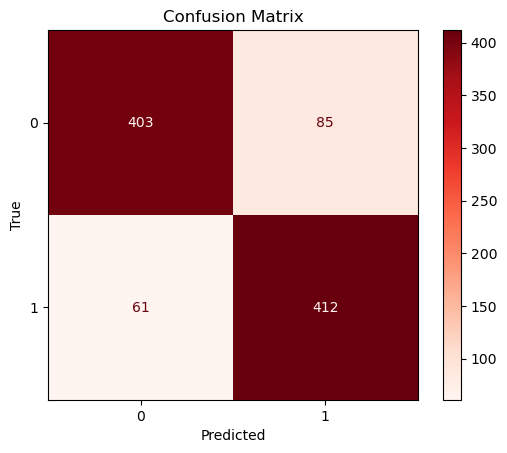

In [32]:
# Matriz de confusion
cm_lr_2 = confusion_matrix(y_test, y_pred_lr_2)

# Crear una instancia de ConfusionMatrixDisplay con la matriz de confusión
cm_lr_2_display = ConfusionMatrixDisplay(confusion_matrix=cm_lr_2)

# Mostrar la matriz de confusión utilizando la función plot() de ConfusionMatrixDisplay
cm_lr_2_display.plot(cmap='Reds')

# Añadir etiquetas y títulos
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Mostrar la matriz de confusión
plt.show()

In [33]:
# Crear un modelo de regresión logística y ajustarlo a los datos de entrenamiento
lr_3= LogisticRegression(max_iter=1000,solver='newton-cg')
lr_3.fit(X_train, y_train)

# Hacer predicciones en los datos de prueba y calcular la precisión
y_pred_lr_3 = lr_3.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_lr_3)

print("Precisión de la regresión logística:", accuracy)
# Metricas de evaluacion
print('Exactitud sobre test: %.2f' % accuracy_score(y_test, y_pred_lr_3))
print("Recall: {}".format(recall_score(y_test, y_pred_lr_3, pos_label=1)))
print("Precisión: {}".format(precision_score(y_test, y_pred_lr_3, pos_label=1)))
print("Puntuación F1: {}".format(f1_score(y_test, y_pred_lr_3, pos_label=1)))

Precisión de la regresión logística: 0.8480749219562955
Exactitud sobre test: 0.85
Recall: 0.86892177589852
Precisión: 0.8303030303030303
Puntuación F1: 0.8491735537190082


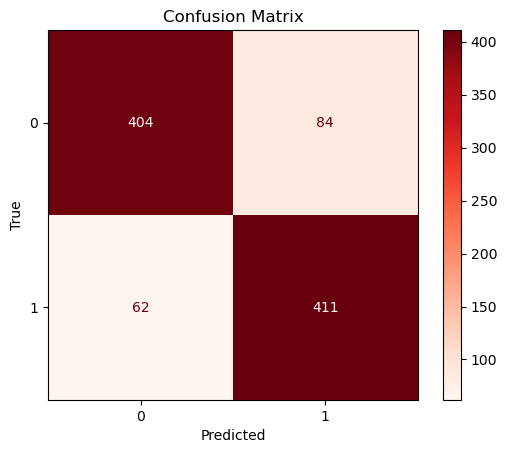

In [34]:
# Matriz de confusion
cm_lr_3 = confusion_matrix(y_test, y_pred_lr_3)

# Crear una instancia de ConfusionMatrixDisplay con la matriz de confusión
cm_lr_3_display = ConfusionMatrixDisplay(confusion_matrix=cm_lr_3)

# Mostrar la matriz de confusión utilizando la función plot() de ConfusionMatrixDisplay
cm_lr_3_display.plot(cmap='Reds')

# Añadir etiquetas y títulos
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Mostrar la matriz de confusión
plt.show()

### OpenAI fine tuned classification
Se intenta utilizar un algoritmo usando tecnologia de punta, no se logra ka total implementacion debido a que tarda mucgo tiempo

In [35]:
!pip install --upgrade openai

In [36]:
import openai

In [37]:
df_copy = df_reviews.copy()
df_copy['sentimiento'].replace({0 : 'negativo', 1 : 'positivo'}, inplace=True)
df_copy.rename(columns={'review_es': 'prompt', 'sentimiento': 'completion'}, inplace=True)
df_copy.head(5)

,Unnamed: 0,prompt,completion
0,0,si busc pelicul guerr tipic asi not aficion gu...,positivo
1,1,supong director pelicul luj sent busc abrig gr...,positivo
2,2,dificil cont pelicul estrop disfrut esper vien...,positivo
3,3,pelicul comienz lent estil vid wallac napalm a...,positivo
4,4,pelicul verdader accion maxim expresion mejor ...,positivo


In [38]:
df_copy.to_json("movies.jsonl", orient='records', lines=True)

In [39]:
!pip install --upgrade openai
!openai tools fine_tunes.prepare_data -f movies.jsonl -q

Analyzing...

- Your file contains 4803 prompt-completion pairs
- The input file should contain exactly two columns/keys per row. Additional columns/keys present are: ['Unnamed: 0']
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- There are 2 duplicated prompt-completion sets. These are rows: [1747, 3786]
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples. If you intend to do open-ended generation, then you should leave the prompts empty
- The completion sho

In [40]:
import os
os.environ["OPENAI_API_KEY"] = "your key"

In [41]:
!openai api fine_tunes.create -t "movies_prepared_train.jsonl" -m ada

Error: Incorrect API key provided: your key. You can find your API key at https://platform.openai.com/account/api-keys. (HTTP status code: 401)


## Resultados
Se prueba el modelo con el conjunto de datos sin clasificar
Primero se preparan estos datos, luego se carga el modelo, se realizan las predicciones y se evaluan

In [42]:
df_reviews_new = pd.read_csv('./data/MovieReviewsPruebas.csv')
# Muestra el numero de filas y columnas del dataframe
print("tamano set pruebas: ",df_reviews_new.shape)
print(df_reviews.head(5))
# Muestra el tipo de datos de cada columna
print(df_reviews_new.dtypes)
# Muestra la cantidad de valores nulos para la columna review_es
print("valores nulos de review: ", df_reviews_new['review_es'].isnull().sum())
print("valores duplicados de review: ", df_reviews['review_es'].duplicated().sum())

# Primero creamos el diccionario de los idiomas en los que estan los comentarios
langs2 = {}
# Luego iteramos sobre cada comentario y determinamos su idioma
for index, row in df_reviews_new.iterrows():
    if detect(row['review_es']) not in langs2:
        langs2[detect(row['review_es'])] = 1
    else:
        langs2[detect(row['review_es'])] += 1

print(langs)

tamano set pruebas:  (300, 2)
   Unnamed: 0                                          review_es  sentimiento
0           0  si busc pelicul guerr tipic asi not aficion gu...            1
1           1  supong director pelicul luj sent busc abrig gr...            1
2           2  dificil cont pelicul estrop disfrut esper vien...            1
3           3  pelicul comienz lent estil vid wallac napalm a...            1
4           4  pelicul verdader accion maxim expresion mejor ...            1
Unnamed: 0     int64
review_es     object
dtype: object
valores nulos de review:  0
valores duplicados de review:  2
{'es': 4803, 'en': 196, 'id': 1}


In [43]:
# Eliminar repetidos
df_reviews_new['review_es'].drop_duplicates(inplace=True)
#Eliminar comentarios en ingles: Iteramos en cada una de las filas del dataframe
for index, row in df_reviews_new.iterrows():
    # Si el valor de la fila es en la elimina
    if detect(row['review_es']) != 'es':
        df_reviews_new.drop(index, inplace=True)

# Seteamos las stopwords en español
df_reviews_new['review_es'] = df_reviews_new['review_es'].apply(lambda x: ' '.join([snowball_stemmer.stem(word.lower()) for word in wordpunct_tokenize(x) if (word.isalpha() and word.lower() not in stop_words)]))
df_reviews_new['review_es'].head(5)

# Usamos el CountVectorizer() que nos da la cuenta de cada de cada palabra para cada review, lo cual podemos usar para los modelos que crearemos a continuación.
# Extraer la cuenta de cada palabra para cada review
X_new = vectorizer.transform(df_reviews_new['review_es'])


In [44]:
#y_pred_lr_3_new = lr_3.predict(X_new)


# Exportación del modelo
Ahora realizaremos los pasos correspondientes a la exportación del mejor modelo para desplegarlo al púbico. Por lo que usaremos pipelines para completar esta tarea. De esta forma, primero debemos exportar el mejor modelo. Dados los resultados obtenidos, nos dimos cuenta que la diferencia entre la regresión logística y Random forest (los cuales obtenían sultados similares) se daba en la clasificación de falsos positivos y falsos negativos, por lo que consideramos usar la regresión logística como mejor modelo ya que para el negocio es mejor dejar una película no tan querida por el público a sacar del catálogo una película que si gusta.
Ahora, el pipeline debe ser de la siguiente forma:
- Eliminar los comentarios que están en ingles.
- Eliminar los duplicados
- Eliminar nulos
- Cambiar el string de la columna de "Sentimiento" de positivo y negativo por 0 y 1
- Hacemos la tokenización de las palabras de los reviews
- Vectorizamos
- Aplicamos el modelo
Una vez se haya hecho el pipeline, entrenaremos nuevamente el modelo y lo exportaremos usando la librería pickle

In [45]:
# Hacemos los imports necesarios para que funcione el modelo
import joblib as jb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Funcion para eliminar los comentarios que no esten en es
def drop_lang(x):
    for index, row in x.iterrows():
        if detect(row['review_es']) != 'es':
            x.drop(index, inplace=True)
    return x

# Funcion para cambiar los valores de la columna sentimiento
def change_sentiment(x):
    x['sentimiento'].replace({'negativo' : 0, 'positivo' : 1}, inplace=True)
    return x

# Funcion para eliminar los duplicados y los nulos
def dropper(x):
    x = x.drop(["Unnamed: 0"], axis=1) # Assign the modified DataFrame to x
    x['review_es'].drop_duplicates(inplace=True)
    x['review_es'].dropna(inplace=True)
    return x

# Funcion para eliminar las stopwords y hacer stemming (Tokenizing)
def clean_text(x):
    x = x.apply(lambda x: ' '.join([snowball_stemmer.stem(word.lower()) for word in wordpunct_tokenize(x) if (word.isalpha() and word.lower() not in stop_words)]))
    return x


Una vez definimos las funciones que nos ayudaran en la transformación de los comentarios recibidos, procedemos a crear el pipeline del modelo, entrenarlo y probarlo para posteriormente exportarlo.

In [46]:
vectorizer = jb.load('./data/count_vectorizer.pkl')
preprocessing = Pipeline([
    ('drop_lang', FunctionTransformer(drop_lang)),
    ('dropper', FunctionTransformer(dropper)),
    ('change_sentiment', FunctionTransformer(change_sentiment)),
])

model = Pipeline([
    ('clean_text', FunctionTransformer(clean_text)),
    ('Vectorizer', vectorizer),
    ('Model', LogisticRegression(max_iter=1000,solver='newton-cg'))
])

# Definimos las variables que usaremos para entrenar y probar el modelo, estas deben ser los datos sin preprocesar
df_reviews_model = pd.read_csv('./data/MovieReviews.csv')

# Limpiamos los datos
df_reviews_model = preprocessing.fit_transform(df_reviews_model)

In [47]:
X_train_model, X_test_model, y_train_model, y_test_model = train_test_split(df_reviews_model["review_es"], df_reviews_model['sentimiento'], test_size=0.3, random_state=42)
# Entrenamos el modelo
modelo_1 = model.fit(X_train_model, y_train_model)

In [48]:
# Ahora prombamos el modelo
y_model_pred = model.predict(X_test_model)
accuracy = accuracy_score(y_test_model, y_model_pred)
print('Accuracy:', accuracy)

Accuracy: 0.8272033310201249


Por ultimo, exportamos el modelo. Vamos a utilizar pickle debido a que joblib presenta problemas al exportar el modelo.

In [49]:
import pickle
pickle.dump(model, open('./data/modelo_1.pkl', 'wb'))